In [45]:
# import the libraries

import pandas as pd
import numpy as np

# machine learning models.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


#OpenCV for image processing.
import cv2

# file and directory handling.
import os
#For image manipulation.
from PIL import Image

# machine learning workflows.
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

# metrics for model evaluation.
from sklearn.metrics import accuracy_score

# image processing libraries.
from skimage import color
from skimage.feature import hog, daisy
from skimage.exposure import rescale_intensity, adjust_log

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [46]:
def draw_confusion_matrix(y_test, y_pred, labels=None):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation="nearest", cmap="coolwarm")
    plt.title("Confusion Matrix", fontsize = 16)
    plt.colorbar()
    
    label_len = cm.shape[0]
    tick_marks = np.arange(label_len)
    if labels == None:
        labels = range(label_len)

    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)

    fmt = "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=10
            )
    plt.ylabel("True Labels", fontsize=14)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    plt.show()



In [47]:
def read_data(csv, img_dir, amount=1, useCV2=True):
    data = pd.read_csv(csv)
    
    # Apply filter for test or development mode
    num = int(data.shape[0] * amount)
    print("num =",num)
    
    y = data["label"].values[:num]
    print("y =",y)
    
    x_file_name = data["im_name"][:num]
    # print("x_file_name =\n",x_file_name)

    x = []
    # extract features
    for i in x_file_name:
        if useCV2:
            img = cv2.imread(os.path.join(img_dir, i))
            # print("img =\n",img)
        else:
            img = np.array(Image.open(os.path.join(img_dir, i)))

        x.append(img)

    print(f"Read: {len(x)}")

    return x, y

In [48]:
def adjust_contrast(imgs):
    result = []
    for img in imgs:
        v_min, v_max = np.percentile(img, (0.2, 99.8))
        logarithmic_corrected = adjust_log(img, 1)
        better_contrast = rescale_intensity(
            logarithmic_corrected, in_range=(v_min, v_max)
        )
        result.append(better_contrast)

    return result

In [49]:
def apply_augmentation(imgs, y, actions=["flip_horizontal", "rotation", "noise", "flip_vertical", "flip_both", "brightness"]):
    new_imgs = []
    new_y = []

    for idx, img in enumerate(imgs):
        new_imgs.append(img)
        new_y.append(y[idx])

        if "flip_horizontal" in actions:
            new_imgs.append(cv2.flip(img, 1))
            new_y.append(y[idx])
            
        if "flip_vertical" in actions:
            new_imgs.append(cv2.flip(img, 0)) 
            new_y.append(y[idx])
            
        if "flip_both" in actions:
            new_imgs.append(cv2.flip(img, -1))  
            new_y.append(y[idx])

        if "rotation" in actions:
            angle = np.random.uniform(-45, 45)
            rotation_matrix = cv2.getRotationMatrix2D(
                (img.shape[1] / 2, img.shape[0] / 2), angle, 1
            )
            new_imgs.append(
                cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))
            )
            new_y.append(y[idx])

        if "noise" in actions:
            noise = np.random.normal(0, 20, img.shape).astype(np.uint8)
            new_imgs.append(cv2.add(img, noise))
            new_y.append(y[idx])
            
        if "brightness" in actions:
            factor = np.random.uniform(0.8, 1.2)  # Smaller range for more natural changes
            offset = np.random.randint(-50, 50)  # Random offset for brightness adjustment
            brightness_img = cv2.convertScaleAbs(img, alpha=factor, beta=offset)
            new_imgs.append(brightness_img)
            new_y.append(y[idx])

    return new_imgs, np.array(new_y)




In [50]:
hog_scaler = StandardScaler()
daisy_scaler =  StandardScaler()
eoh_scaler =  StandardScaler()
pool_scaler =  StandardScaler()
is_fitted = False

# reduces the image size and retains spatial information at a lower resolution.
def average_pooling(image, pool_size):
    pooled_height, pooled_width = image.shape[0] // pool_size, image.shape[1] // pool_size
    
    pooled_image = (
        image.reshape(
            pooled_height, pool_size, pooled_width, pool_size, image.shape[2]
        )
        .mean(axis=(1, 3))
    )

    return pooled_image

def compute_gradients(img):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    angle = (np.arctan2(sobely, sobelx) * 180 / np.pi) % 360  # Normalize to [0, 360)
    return magnitude, angle

def compute_cell_histogram(cell_magnitude, cell_angle, num_bins):
    histogram, _ = np.histogram(
        cell_angle,
        bins=num_bins,
        range=(0, 360),
        weights=cell_magnitude
    )
    return histogram

def normalize_feature_vector(feature_vector):
    norm = np.linalg.norm(feature_vector)
    return feature_vector / norm if norm > 0 else feature_vector

def eoh(img, num_bins=9, cell_size=8):
    # Compute gradient magnitude and angle
    magnitude, angle = compute_gradients(img)

    # Determine number of cells in the image
    num_cells_x = img.shape[1] // cell_size
    num_cells_y = img.shape[0] // cell_size

    # Compute histograms for each cell
    histograms = [
        compute_cell_histogram(
            magnitude[i * cell_size:(i + 1) * cell_size, j * cell_size:(j + 1) * cell_size],
            angle[i * cell_size:(i + 1) * cell_size, j * cell_size:(j + 1) * cell_size],
            num_bins
        )
        for i in range(num_cells_y)
        for j in range(num_cells_x)
    ]

    # Flatten and normalize the feature vector
    eoh_feature = normalize_feature_vector(np.concatenate(histograms))
    return eoh_feature


def feature_extraction(imgs):
    print(f"Before Extraction: {imgs[0].flatten().shape[0]}")
    X_hog, X_daisy, X_eoh, X_pooling = [], [], [], []


    for img in adjust_contrast(imgs):
        gray = color.rgb2gray(img)
        fd = hog(img, channel_axis=2)
        X_hog.append(fd)
        X_daisy.append(
            daisy(
                gray,
                radius=7,
                step=7,
                rings=1,
                orientations=8,
                normalization="l2",
            ).flatten()
        )
        X_eoh.append(eoh(img))
        X_pooling.append(average_pooling(img, 4).flatten())

    global is_fitted
    if is_fitted:
        X_hog = hog_scaler.transform(X_hog)
        X_daisy = daisy_scaler.transform(X_daisy)
        X_eoh = eoh_scaler.transform(X_eoh)
        X_pooling = pool_scaler.transform(X_pooling)
    else:
        X_hog = hog_scaler.fit_transform(X_hog)
        X_daisy = daisy_scaler.fit_transform(X_daisy)
        X_eoh = eoh_scaler.fit_transform(X_eoh)
        X_pooling = pool_scaler.fit_transform(X_pooling)
        is_fitted = True

    X = np.hstack([X_hog, X_daisy, X_eoh, X_pooling])
    
    print(f"After Extraction: {X.shape[1]}\n")
    return X

In [51]:
# d: development t: test p: prediction
MODE = "t"
TRAIN_CSV = "train.csv"
TRAIN_IMGS_DIR = "train_ims"
TEST_CSV = "test.csv"
TEST_IMGS_DIR = "test_ims"
SEED = 1

# DEBUG
# Load the CSV file into a DataFrame
df1 = pd.read_csv(TRAIN_CSV)
df2 = pd.read_csv(TEST_CSV)
# Get the number of rows in the CSV file
print(f'The train.csv file contains {len(df1)} rows.')
print(f'The test.csv file contains {len(df2)} rows.')
# List all files in the directory
test_img_files = os.listdir('./test_ims')
train_img_files = os.listdir('./train_ims')
# Get the number of image files
print(f'The test_ims directory contains {len(test_img_files)} images.')
print(f'The train_ims directory contains {len(train_img_files)} images.')

The train.csv file contains 50000 rows.
The test.csv file contains 10000 rows.
The test_ims directory contains 10000 images.
The train_ims directory contains 50000 images.


In [52]:
def load_data(mode, train_csv, train_imgs_dir, test_csv=None, test_imgs_dir=None, seed=42):
    def get_data(csv_path, img_dir, subset_fraction=1.0):
        return read_data(csv_path, img_dir, subset_fraction)
    
    global X, y

    if mode == "d":  # Development mode: Load only 15% of the training dataset
        X, y = get_data(train_csv, train_imgs_dir, subset_fraction=0.2)
    else:  # Full training mode
        X, y = get_data(train_csv, train_imgs_dir)

    if mode == "p":  # Production mode: Use full dataset for training, separate test dataset
        if not test_csv or not test_imgs_dir:
            raise ValueError("Test CSV and images directory must be provided in 'p' mode.")
        X_test, y_test = get_data(test_csv, test_imgs_dir)
        X_train, y_train = X, y
    else:  # Split into training and testing datasets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = load_data(
    mode=MODE,
    train_csv=TRAIN_CSV,
    train_imgs_dir=TRAIN_IMGS_DIR,
    test_csv=TEST_CSV,
    test_imgs_dir=TEST_IMGS_DIR,
    seed=SEED
)
  
    
print("length of all images =",len(X))
print("first image =",len(X[0]))
print("first image =",X[0])
print("first row of the first image =",len(X[0][0]))
print("first row of the first image =",X[0][0])
print("RGB of first pixel of the first row =",len(X[0][0][0]))
print("RGB of first pixel of the first row =",X[0][0][0])

num = 50000
y = [6 2 1 ... 5 9 0]
Read: 50000
length of all images = 50000
first image = 32
first image = [[[246 242 237]
  [249 246 238]
  [241 239 228]
  ...
  [ 25  62  28]
  [ 35  66  33]
  [ 37  67  32]]

 [[251 245 238]
  [242 238 227]
  [237 234 220]
  ...
  [ 29  66  32]
  [ 27  60  26]
  [ 28  60  25]]

 [[228 222 209]
  [220 216 198]
  [214 210 191]
  ...
  [ 29  71  36]
  [ 35  72  38]
  [ 28  63  29]]

 ...

 [[219 205 177]
  [210 196 167]
  [199 189 155]
  ...
  [161 156 117]
  [166 172 131]
  [117 127  84]]

 [[210 197 171]
  [203 191 163]
  [186 177 143]
  ...
  [148 145 107]
  [128 136  95]
  [118 132  90]]

 [[229 218 191]
  [219 208 180]
  [193 184 150]
  ...
  [153 150 112]
  [135 144 104]
  [122 139  96]]]
first row of the first image = 32
first row of the first image = [[246 242 237]
 [249 246 238]
 [241 239 228]
 [210 210 194]
 [170 169 148]
 [178 178 154]
 [164 167 142]
 [156 158 136]
 [145 147 128]
 [177 177 163]
 [214 214 208]
 [216 217 215]
 [209 208 210]
 [21

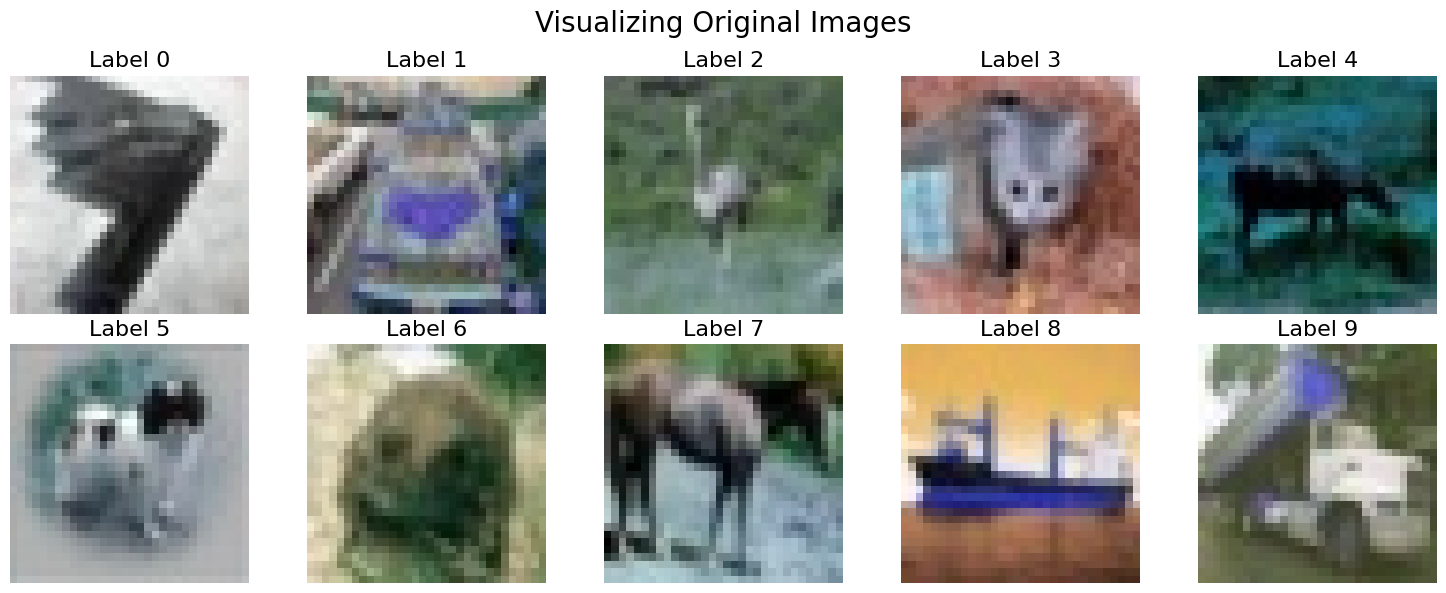

In [53]:
def plot_images(X, y, title, contrast_function=None, num_rows=2, num_cols=5):

    fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 6))
    unique_labels = np.unique(y)

    for i, label in enumerate(unique_labels):
        if i >= num_rows * num_cols:  # Avoid plotting more than the grid allows
            break
        row, col = divmod(i, num_cols)
        # Find the first image with the current label
        img = np.array(X)[y == label][0]
        if contrast_function:
            img = contrast_function([img])[0]  # Apply contrast adjustment
        ax[row, col].imshow(img)
        ax[row, col].set_title(f"Label {label}", fontsize=16)
        ax[row, col].axis("off")

    # Remove unused subplots
    for i in range(len(unique_labels), num_rows * num_cols):
        row, col = divmod(i, num_cols)
        ax[row, col].axis("off")

    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()


plot_images(X, y, title="Visualizing Original Images")


In [54]:
X_train, y_train = apply_augmentation(X_train, y_train, ["brightness","flip_horizontal"])
# X_train, y_train = apply_augmentation(X_train, y_train, ["noise"])
# X_train, y_train = apply_augmentation(X_train, y_train, ["rotation"])

In [55]:
X_train = feature_extraction(X_train)
print("X_train shape =",X_train.shape)
unique_labels, label_counts = np.unique(y_train, return_counts=True)
print(f"Total Training Data: {y_train.shape[0]}")
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count}")

Before Extraction: 3072
After Extraction: 1308

X_train shape = (120000, 1308)
Total Training Data: 120000
Label 0: 12066
Label 1: 11997
Label 2: 12150
Label 3: 11877
Label 4: 11913
Label 5: 12033
Label 6: 11811
Label 7: 12057
Label 8: 12030
Label 9: 12066


In [56]:
X_test = feature_extraction(X_test)
unique_labels, label_counts = np.unique(y_test, return_counts=True)
print(f"Total Testing Data: {y_test.shape[0]}")
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count}")

Before Extraction: 3072
After Extraction: 1308

Total Testing Data: 10000
Label 0: 988
Label 1: 1013
Label 2: 988
Label 3: 1048
Label 4: 1024
Label 5: 982
Label 6: 1018
Label 7: 981
Label 8: 1010
Label 9: 948


In [57]:
# # KNN model development

# param_grid = {
#     'n_neighbors': range(2, 30, 3),
#     'weights': ['uniform', 'distance'],
#     'p': [1, 2]
# }

# knn = KNeighborsClassifier()

# grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print(f'Best parameters: {best_params}')
# print(f'Best cross-validation accuracy: {best_score}')

# results = pd.DataFrame(grid_search.cv_results_)

# columns_to_display = [
#     'param_n_neighbors',  
#     'param_weights',     
#     'param_p',           
#     'mean_test_score',    
#     'std_test_score'    
# ]

# results_df = results[columns_to_display]

# results_df = results_df.sort_values(by='mean_test_score', ascending=False)

# # Display the results
# print(results_df)

# # Train the KNN classifier with the best parameters
# model = KNeighborsClassifier(**best_params)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)





In [58]:
# logistic regression model development


# Define the parameter grid
# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'penalty': ['l2'],
#     'max_iter': [500]
# }


# # Initialize Logistic Regression
# lr = LogisticRegression(random_state=SEED)

# # Perform GridSearchCV
# grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# # Best parameters and score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print(f"Best parameters: {best_params}")
# print(f"Best cross-validation accuracy: {best_score}")



In [59]:
# #Show the scatter plot of different C
# results = pd.DataFrame(grid_search.cv_results_)
# # Filter results for l2 penalty only
# l2_results = results[results['param_penalty'] == 'l2']
# # Scatter plot for l2 results
# plt.figure(figsize=(10, 6))
# plt.scatter(l2_results['param_C'], l2_results['mean_test_score'], color='blue', s=100, label='Penalty: l2')
# # Add labels and title
# plt.xscale('log')  # Use log scale for `C` values
# plt.xlabel('C (Regularization Strength)', fontsize=14)
# plt.ylabel('Mean Accuracy', fontsize=14)
# plt.title('GridSearchCV Results for L2 Penalty', fontsize=16)
# plt.legend(fontsize=12)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# param_grids = [
#     {'C': [0.001], 'penalty': ['l2'], 'solver': ['liblinear'], 'multi_class': ['ovr'], 'max_iter': [500]},
#     {'C': [0.001], 'penalty': ['l2'], 'solver': ['lbfgs'], 'multi_class': ['multinomial'], 'max_iter': [500]},
#     {'C': [0.001], 'penalty': ['l2'], 'solver': ['newton-cg'], 'multi_class': ['multinomial'], 'max_iter': [500]},
#     {'C': [0.001], 'penalty': ['l2'], 'solver': ['saga'], 'multi_class': ['multinomial'], 'max_iter': [500]}
# ]

# # Initialize results list
# results = []

# # Loop through parameter grids
# for i, param_grid in enumerate(param_grids):
#     # Initialize Logistic Regression
#     lr = LogisticRegression(random_state=SEED)
    
#     # Perform GridSearchCV
#     grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', cv=5)
#     grid_search.fit(X_train, y_train)
    
#     # Store results
#     results.append({
#         'solver': param_grid['solver'][0],
#         'multi_class': param_grid['multi_class'][0],
#         'accuracy': grid_search.best_score_
#     })


In [60]:
# Convert results to DataFrame

# results_df = pd.DataFrame(results)
# print(results_df)

In [61]:
# LR model with best parameters

# model = LogisticRegression(C=0.001, penalty='l2', solver='saga', multi_class='multinomial', max_iter=500)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

In [62]:
# SVM model development

# def display_results(grid_search, kernel_name):
#     # Extract results
#     results = pd.DataFrame(grid_search.cv_results_)
    
#     # Select relevant columns for the kernel
#     if kernel_name == 'linear':
#         columns_to_display = ['param_C', 'mean_test_score', 'std_test_score']
#     elif kernel_name == 'rbf':
#         columns_to_display = ['param_C', 'param_gamma', 'mean_test_score', 'std_test_score']
#     elif kernel_name == 'poly':
#         columns_to_display = ['param_C', 'param_gamma', 'param_degree', 'mean_test_score', 'std_test_score']
    
#     # Filter and sort results
#     results_df = results[columns_to_display].sort_values(by='mean_test_score', ascending=False)
#     print(f"\nComparisons for {kernel_name} kernel:")
#     print(results_df)

# Linear kernel
# param_grid_linear = {
#     'C': [0.001, 0.01, 0.1, 1, 10],
#     'kernel': ['linear']
# }
# grid_search_linear = GridSearchCV(estimator=SVC(random_state=SEED), param_grid=param_grid_linear, cv=3, scoring='accuracy')
# grid_search_linear.fit(X_train, y_train)
# display_results(grid_search_linear, 'linear')

# RBF kernel
# param_grid_rbf = {
#     'C': [2, 3, 4],
#     'kernel': ['rbf'],
#     'gamma': ['scale', 'auto']
# }
# grid_search_rbf = GridSearchCV(estimator=SVC(random_state=SEED), param_grid=param_grid_rbf, cv=3, scoring='accuracy')
# grid_search_rbf.fit(X_train, y_train)
# display_results(grid_search_rbf, 'rbf')

# Polynomial kernel
# param_grid_poly = {
#     'C': [0.1, 1, 10, 100],
#     'kernel': ['poly'],
#     'gamma': ['scale', 'auto', 0.01, 0.1, 1],
#     'degree': [2, 3, 4]
# }
# grid_search_poly = GridSearchCV(estimator=SVC(random_state=SEED), param_grid=param_grid_poly, cv=3, scoring='accuracy')
# grid_search_poly.fit(X_train, y_train)
# display_results(grid_search_poly, 'poly')

In [63]:
#Final implementation model with best parameters (SVM)

model = SVC(C=2.5, random_state=SEED, kernel="rbf", gamma="scale")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Test Accuracy: 0.7837
Train Accuracy: 0.989825

Classification Report (Test Set):
              precision    recall  f1-score   support

     Class 0       0.81      0.84      0.82       988
     Class 1       0.89      0.88      0.88      1013
     Class 2       0.72      0.70      0.71       988
     Class 3       0.63      0.61      0.62      1048
     Class 4       0.74      0.75      0.74      1024
     Class 5       0.69      0.68      0.69       982
     Class 6       0.82      0.84      0.83      1018
     Class 7       0.83      0.80      0.82       981
     Class 8       0.86      0.88      0.87      1010
     Class 9       0.86      0.86      0.86       948

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



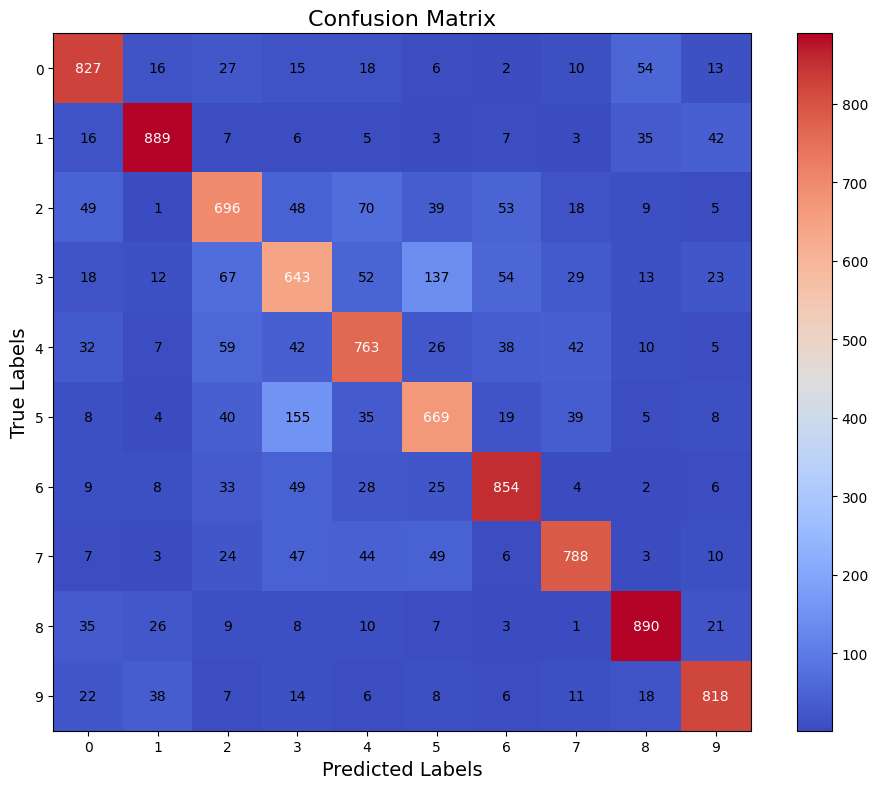

In [64]:
# Check the accuracy of the model

if MODE != "p":
    test_accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", test_accuracy)
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print("Train Accuracy:", train_accuracy)
    
    # Generate and print classification report
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred, target_names=[f"Class {label}" for label in np.unique(y_test)]))
    
    # draw_confusion_matrix for performance evaluation
    draw_confusion_matrix(y_test, y_pred)
else:
    df = pd.read_csv(TEST_CSV)
    df["label"] = y_pred
    df.to_csv(TEST_CSV, index=False)
    # check the model is overfitting or not
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print("Train Accuracy:", train_accuracy)